In [6]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from pyESN import ESN
import talib
import multiprocessing
from deap import base, creator, tools, algorithms
import warnings

# DEAP creator 객체는 한 번만 생성되어야 합니다.
try:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
except RuntimeError:
    pass
try:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
except RuntimeError:
    pass

warnings.filterwarnings('ignore')

# 사용자가 제공한 모든 커스텀 모듈들을 가정하고 임포트합니다.
import RSI as rsi
import CPM as cpm
import importlib
import MovingAverage as ma
import Stochastic as st
import CandleChart as cc
import ROC as roc
import CV_ESN as cv_esn

# 모든 모듈을 다시 로드하여 최신 상태를 반영
importlib.reload(ma)
importlib.reload(cpm)
importlib.reload(st)
importlib.reload(rsi)
importlib.reload(cc)
importlib.reload(roc)
importlib.reload(cv_esn)

<module 'CV_ESN' from '/Users/munminjung/Capstone/CV_ESN.py'>

In [ ]:
# --- 1. 데이터 수집 및 전처리 ---
name = 'JPM'
ticker = yf.Ticker(name)
ori_df = ticker.history(start='2015-07-22', end='2025-07-22', interval='1d', auto_adjust=False)

print(f"{name} 데이터 로드 완료. 결측치 수:\n", ori_df.isnull().sum())

plt.figure(figsize=(10, 5))
plt.plot(ori_df.index, ori_df['Close'], label='Close Price', color='blue')
plt.title(f'{name} - Close Price (10y)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df = ori_df.copy()


CPM 모델 적용 중...


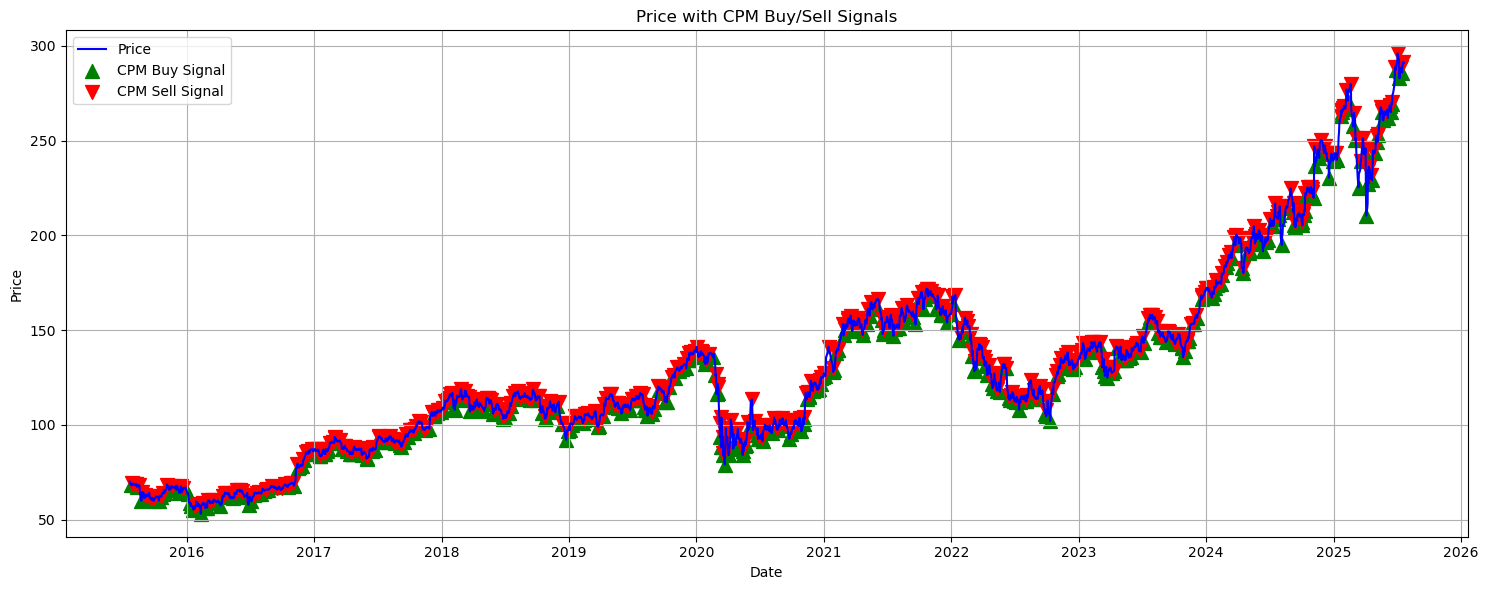

In [8]:
# --- 2. CPM 모델 적용 ---
print("\nCPM 모델 적용 중...")
cpm_points, df_with_cpm = cpm.cpm_model(df, column='Close', P=0.09, T=5)

cpm_indices = df_with_cpm[df_with_cpm['is_cpm_point'] == True].index
cpm_prices = df_with_cpm.loc[cpm_indices, 'Close']

buy_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == -1].index
sell_indices = df_with_cpm[df_with_cpm['cpm_point_type'] == 1].index

plt.figure(figsize=(15, 6))
plt.plot(df.index, df_with_cpm['Close'], label='Price', color='blue')
plt.scatter(buy_indices, df_with_cpm.loc[buy_indices, 'Close'], label='CPM Buy Signal', marker='^', color='green', s=100)
plt.scatter(sell_indices, df_with_cpm.loc[sell_indices, 'Close'], label='CPM Sell Signal', marker='v', color='red', s=100)
plt.title("Price with CPM Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 데이터프레임 인덱스 정제
if not isinstance(df_with_cpm.index, pd.DatetimeIndex):
    df_with_cpm.index = pd.to_datetime(df_with_cpm.index)
if df_with_cpm.index.tz is not None:
    df_with_cpm.index = df_with_cpm.index.tz_localize(None)
df_with_cpm.index = df_with_cpm.index.normalize()


# --- 3. 데이터 분할 ---
total_len = len(df)
train_end = int(total_len * 0.8)
train_df = df_with_cpm.iloc[:train_end].copy()
test_df = df_with_cpm.iloc[train_end:].copy()

In [ ]:
# --- 4. 기술적 지표(TA) 유전 알고리즘(GA) 최적화 (훈련 데이터에서) ---
# 4.1. 이동평균 (MA)
print("\n이동평균(MA) 전략 최적화 시작...")
while True:
    try:
        ma_best_params, ma_best_fitness, _ = ma.run_MA_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in MA optimization: {e}. Retrying...")
        continue
print("\n--- MA 최적화 결과 ---")
print("Best Parameters:", ma_best_params)
print("Best Fitness:", ma_best_fitness)

# 4.2. RSI (상대강도지수)
print("\nRSI 전략 최적화 시작...")
while True:
    try:
        rsi_best_params, rsi_best_fitness, _ = rsi.run_RSI_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in RSI optimization: {e}. Retrying...")
        continue
print("\n--- RSI 최적화 결과 ---")
print("Best Parameters:", rsi_best_params)
print("Best Fitness:", rsi_best_fitness)

# 4.3. CandleChart (캔들스틱 시너지)
print("\n캔들스틱 시너지 전략 최적화 시작...")
while True:
    try:
        cc_best_params, cc_best_fitness, _ = cc.run_candlestick_synergy_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in CC optimization: {e}. Retrying...")
        continue
print("\n--- 캔들스틱 시너지 최적화 결과 ---")
print("Best Parameters:", cc_best_params)
print("Best Fitness:", cc_best_fitness)

# 4.4. ROC (Rate of Change)
print("\nROC 전략 최적화 시작...")
while True:
    try:
        roc_best_params, roc_best_fitness, _ = roc.run_roc_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in ROC optimization: {e}. Retrying...")
        continue
print("\n--- ROC 최적화 결과 ---")
print("Best Parameters:", roc_best_params)
print("Best Fitness:", roc_best_fitness)

# 4.5. Stochastic
print("\nStochastic 전략 최적화 시작...")
while True:
    try:
        st_best_params, st_best_fitness, _ = st.run_stochastic_ga_optimization(train_df)
        break
    except Exception as e:
        print(f"Error in Stochastic optimization: {e}. Retrying...")
        continue
print("\n--- Stochastic 최적화 결과 ---")
print("Best Parameters:", st_best_params)
print("Best Fitness:", st_best_fitness)


ESN 모델 롤링-포워드 교차 검증 시작...
최적화된 파라미터로 데이터프레임에 기술적 지표 신호 생성 중...
2514 4.352832107389973
--- 1. 첫 번째 폴드로 ESN 파라미터 최적화 ---


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

gen	nevals	avg     	std    	min     	max    
0  	30    	-16.3686	20.7254	-51.8925	24.7599


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

1  	25    	-14.2835	19.8086	-50.6834	24.7599


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

2  	23    	-9.81914	16.9935	-47.2441	24.7599


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

3  	28    	-19.9452	17.9754	-47.941 	17.5747


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

4  	27    	-9.02675	19.9985	-40.509 	42.8759


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

5  	19    	-8.74109	19.4803	-43.2919	25.0705


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

6  	21    	-0.378442	17.2356	-41.0448	25.0705


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

7  	30    	-10.7427 	21.1711	-45.7337	38.3863


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

8  	21    	-1.31545 	18.8051	-33.5934	38.3863


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

9  	27    	3.21083  	20.6102	-36.2033	38.3863


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

10 	25    	-3.49123 	22.542 	-51.8668	38.3863


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

11 	20    	0.279567 	21.447 	-52.232 	38.3863


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

12 	23    	-0.870368	16.1061	-31.2672	24.2126


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

13 	22    	1.65251  	22.2964	-37.6526	53.463 


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

14 	25    	6.77858  	25.4153	-38.3086	53.463 


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]

15 	22    	3.87724  	21.0067	-30.9017	47.3127

GA 최적화 완료 - 최적 하이퍼파라미터: [280.43437673126914, 2.2352518649201585, 0.1779794684340187, 0.4048320611392595]
GA 최적화 완료 - 최고 Return [%]: 53.4630

--- 2. 최적 파라미터로 모든 폴드에 대해 롤링 포워드 검증 ---

--- 폴드 1 / 5 ---

--- 최적화된 파라미터로 최종 ESN 학습 및 백테스팅 ---
  n_reservoir: 280
  spectral_radius: 1.5000
  sparsity: 0.1780
  signal_threshold: 0.4048


Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2019-07-19 00:00:00
End                       2020-05-05 00:00:00
Duration                    291 days 00:00:00
Exposure Time [%]                    40.79602
Equity Final [$]                  15346.30444
Equity Peak [$]                   15346.30444
Commissions [$]                     604.16626
Return [%]                           53.46304
Buy & Hold Return [%]               -18.97129
Return (Ann.) [%]                    71.07983
Volatility (Ann.) [%]                39.56004
CAGR [%]                             44.90236
Sharpe Ratio                          1.79676
Sortino Ratio                         5.68288
Calmar Ratio                          6.93645
Alpha [%]                            58.28904
Beta                                  0.25438
Max. Drawdown [%]                   -10.24729
Avg. Drawdown [%]                    -3.45594
Max. Drawdown Duration      133 days 00:00:00
Avg. Drawdown Duration       24 days 00:00:00
# Trades 

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2020-05-06 00:00:00
End                       2021-02-22 00:00:00
Duration                    292 days 00:00:00
Exposure Time [%]                    40.29851
Equity Final [$]                  14355.31744
Equity Peak [$]                   14355.31744
Commissions [$]                    1256.68282
Return [%]                           43.55317
Buy & Hold Return [%]                65.51458
Return (Ann.) [%]                    57.34461
Volatility (Ann.) [%]                41.28572
CAGR [%]                             36.61683
Sharpe Ratio                          1.38897
Sortino Ratio                         4.05869
Calmar Ratio                          2.77209
Alpha [%]                            11.87003
Beta                                   0.4836
Max. Drawdown [%]                   -20.68645
Avg. Drawdown [%]                    -8.32702
Max. Drawdown Duration      204 days 00:00:00
Avg. Drawdown Duration       61 days 00:00:00
# Trades 

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2021-02-23 00:00:00
End                       2021-12-07 00:00:00
Duration                    287 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                      10000.0
Equity Peak [$]                       10000.0
Return [%]                                0.0
Buy & Hold Return [%]                 7.94104
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
CAGR [%]                                  0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Alpha [%]                                 0.0
Beta                                      0.0
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate 

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2021-12-08 00:00:00
End                       2022-09-26 00:00:00
Duration                    292 days 00:00:00
Exposure Time [%]                    81.59204
Equity Final [$]                   6753.79962
Equity Peak [$]                   10414.63866
Commissions [$]                     211.68404
Return [%]                            -32.462
Buy & Hold Return [%]               -33.55112
Return (Ann.) [%]                   -38.86369
Volatility (Ann.) [%]                16.94362
CAGR [%]                            -28.73148
Sharpe Ratio                         -2.29371
Sortino Ratio                        -1.89878
Calmar Ratio                         -1.10562
Alpha [%]                            -2.82241
Beta                                  0.88342
Max. Drawdown [%]                    -35.1509
Avg. Drawdown [%]                   -14.07672
Max. Drawdown Duration      257 days 00:00:00
Avg. Drawdown Duration       97 days 00:00:00
# Trades 

Backtest.run:   0%|          | 0/200 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2022-09-27 00:00:00
End                       2023-07-17 00:00:00
Duration                    293 days 00:00:00
Exposure Time [%]                    14.42786
Equity Final [$]                  12164.92809
Equity Peak [$]                   12164.92809
Commissions [$]                      121.0549
Return [%]                           21.64928
Buy & Hold Return [%]                44.90317
Return (Ann.) [%]                    27.85111
Volatility (Ann.) [%]                 18.2192
CAGR [%]                             18.35865
Sharpe Ratio                          1.52867
Sortino Ratio                         4.12596
Calmar Ratio                          5.56264
Alpha [%]                             9.02035
Beta                                  0.28125
Max. Drawdown [%]                    -5.00682
Avg. Drawdown [%]                    -2.42198
Max. Drawdown Duration       58 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades 

Backtest.run:   0%|          | 0/502 [00:00<?, ?bar/s]


최종 백테스팅 결과 (최적화된 파라미터):
Start                     2023-07-19 00:00:00
End                       2025-07-21 00:00:00
Duration                    733 days 00:00:00
Exposure Time [%]                     0.39761
Equity Final [$]                  10109.14956
Equity Peak [$]                   10174.08376
Commissions [$]                      39.97056
Return [%]                             1.0915
Buy & Hold Return [%]                88.63533
Return (Ann.) [%]                     0.54535
Volatility (Ann.) [%]                 1.32173
CAGR [%]                              0.37391
Sharpe Ratio                           0.4126
Sortino Ratio                         1.20601
Calmar Ratio                          0.85447
Alpha [%]                             0.79036
Beta                                   0.0034
Max. Drawdown [%]                    -0.63823
Avg. Drawdown [%]                    -0.63823
Max. Drawdown Duration      728 days 00:00:00
Avg. Drawdown Duration      728 days 00:00:00
# Trades 

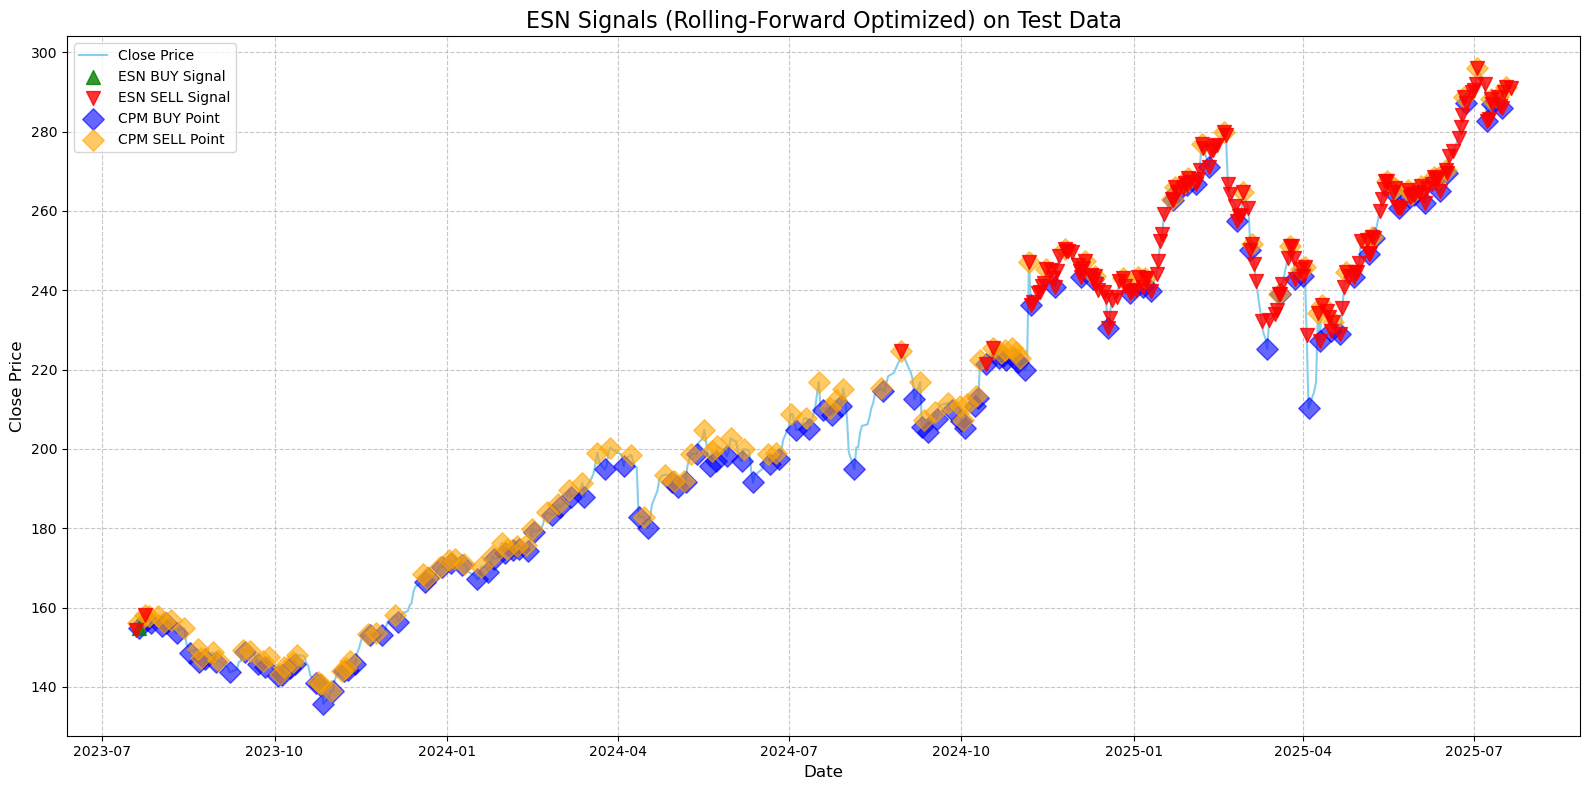

In [10]:
# ESN에 입력될 기술적 지표 목록
Technical_Signals = ['MA_Signals', 'RSI_Signals', 'CC_Signals', 'ROC_Signals', 'Stochastic_Signals']

# --- 5. ESN 롤링-포워드 교차 검증 및 최적화 ---
print("\nESN 모델 롤링-포워드 교차 검증 시작...")

# 롤링 포워드 검증 및 최종 백테스팅에 사용할 TA 신호들을
# CPM 모델이 적용된 데이터프레임(df_with_cpm)에 생성
print("최적화된 파라미터로 데이터프레임에 기술적 지표 신호 생성 중...")

N, n, a, b, c = ma_best_params
df_with_cpm['MA_Signals'] = ma.generate_MA_signals(df_with_cpm, N, n, a, b, c)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

x, overbought_level, oversold_level, p, q = rsi_best_params
df_with_cpm['RSI_Signals'] = rsi.generate_RSI_signals(df_with_cpm, x, overbought_level, oversold_level, p, q)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

cc_a, cc_d, cc_e, cc_f, cc_g, cc_window = cc_best_params
df_with_cpm['CC_Signals'] = cc.generate_synergy_signals(df_with_cpm, cc_a, cc_d, cc_e, cc_f, cc_g, int(cc_window))['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

roc_period, roc_threshold = roc_best_params
df_with_cpm['ROC_Signals'] = roc.generate_roc_signals(df_with_cpm, int(roc_period), roc_threshold)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

st_a, st_b, st_c, st_d = st_best_params
df_with_cpm['Stochastic_Signals'] = st.generate_stochastic_signals(df_with_cpm, st_a, st_b, st_c, st_d)['Type'].map({'BUY': -1, 'SELL': 1}).reindex(df_with_cpm.index).fillna(0).astype(int)

# 모든 신호가 추가된 데이터프레임(df_with_cpm)을 다시 훈련/테스트 데이터로 분할
train_df = df_with_cpm.iloc[:train_end].copy()
test_df = df_with_cpm.iloc[train_end:].copy()


# 롤링-포워드 교차 검증 실행
best_params_cv, cv_returns = cv_esn.esn_rolling_forward(
    df=train_df, # 훈련 데이터프레임을 전달
    technical_signals_list=Technical_Signals,
    n_splits=5,  # 5개 폴드로 분할
    pop_size=30,
    num_generations=15
)


# --- 6. 최종 백테스팅 및 시각화 ---
print("\n최종 ESN 모델 백테스팅 시작...")

# 롤링-포워드 최적화로 찾은 최적의 파라미터를 사용하여 테스트 데이터에 대한 백테스팅 수행
final_backtest_stats, final_signals = cv_esn.perform_final_backtest(
    train_df=train_df,
    test_df=test_df,
    best_params=best_params_cv,
    technical_signals_list=Technical_Signals,
    random_state=42
)

if final_backtest_stats is not None:
    print("\n--- 최종 백테스팅 결과 ---")
    print(final_backtest_stats)

    # 신호 시각화 함수 정의
    def plot_signals(original_df: pd.DataFrame, signals_df: pd.DataFrame, title: str = "ESN Signals with CPM Points"):
        plt.figure(figsize=(16, 8))
        plt.plot(original_df.index, original_df['Close'], label='Close Price', color='skyblue', linewidth=1.5)

        buy_signals = signals_df[signals_df['Predicted_Signals'] == -1]
        plt.scatter(buy_signals.index, buy_signals['Close'],
                    marker='^', color='green', s=100, label='ESN BUY Signal', alpha=0.8, zorder=5)

        sell_signals = signals_df[signals_df['Predicted_Signals'] == 1]
        plt.scatter(sell_signals.index, sell_signals['Close'],
                    marker='v', color='red', s=100, label='ESN SELL Signal', alpha=0.8, zorder=5)

        if 'cpm_point_type' in original_df.columns:
            cpm_buy_points = original_df[original_df['cpm_point_type'] == -1]
            cpm_sell_points = original_df[original_df['cpm_point_type'] == 1]

            plt.scatter(cpm_buy_points.index, cpm_buy_points['Close'],
                        marker='D', color='blue', s=120, label='CPM BUY Point', alpha=0.6, zorder=4)

            plt.scatter(cpm_sell_points.index, cpm_sell_points['Close'],
                        marker='D', color='orange', s=120, label='CPM SELL Point', alpha=0.6, zorder=4)
        else:
            print("경고: 'cpm_point_type' 컬럼이 original_df에 없어 CPM 포인트를 표시할 수 없습니다.")

        plt.title(title, fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Close Price', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    if final_signals is not None:
        plot_signals(test_df, final_signals, title="ESN Signals (Rolling-Forward Optimized) on Test Data")